# 03.EDA

In this notebook, I have exploratory data analysis on two subsetted datasets, Holidays and Washington Metro area.

In [1]:
# Libraries and packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import requests
import json
from bs4 import BeautifulSoup

import time
from selenium import webdriver
import re

In [2]:
# Read dataset
holidays   = pd.read_csv('./assets/holidays.csv', low_memory=False) 
washington = pd.read_csv('./assets/washington.csv', low_memory=False)

print("Holidays dataframe dimensions(shape)  : ", holidays.shape)
print("Washington dataframe dimensions(shape): ", washington.shape)

Holidays dataframe dimensions(shape)  :  (7084008, 31)
Washington dataframe dimensions(shape):  (2204853, 31)


##### Functions for the notebook

In [3]:
# # Examine the null values in the datasets
# def null_check(df):
#     null = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
#     null = null.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (#)'}))
#     null = null.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
#     return null.T.sort_values(by='null values (%)', ascending=False).T

In [4]:
# counting null values in dataframe

def isnull_counter(df):
    foobar = df.isnull().sum(axis=0).reset_index()
    foobar.columns = ['variable', 'missing values']
    foobar['filling factor (%)']=(df.shape[0]-foobar['missing values'])/df.shape[0]*100
    return foobar.sort_values('filling factor (%)').reset_index(drop = True).round(4)

# counting categorical columns' value counts
def value_counter(df):
    foobar = df.value_counts().reset_index()
    foobar.columns = ['value', 'counts']
    foobar['(%)'] = df.value_counts(normalize=True).reset_index(drop=True).round(4)
    return foobar

In [5]:
isnull_counter(holidays)

,variable,missing values,filling factor (%)
0,CancellationCode,6954019,1.8350
1,LateAircraftDelay,5727735,19.1456
2,NASDelay,5727735,19.1456
3,WeatherDelay,5727735,19.1456
4,CarrierDelay,5727735,19.1456
5,SecurityDelay,5727735,19.1456
6,AirTime,145679,97.9436
7,ActualElapsedTime,145679,97.9436
8,ArrDelay,145679,97.9436
9,ArrTime,134024,98.1081


In [6]:
isnull_counter(washington)

,variable,missing values,filling factor (%)
0,CancellationCode,2161504,1.9661
1,LateAircraftDelay,1784905,19.0465
2,NASDelay,1784905,19.0465
3,WeatherDelay,1784905,19.0465
4,CarrierDelay,1784905,19.0465
5,SecurityDelay,1784905,19.0465
6,AirTime,48161,97.8157
7,ActualElapsedTime,48161,97.8157
8,ArrDelay,48161,97.8157
9,ArrTime,44131,97.9985


In [7]:
# currently all the departure/arrival time were set only 4 digits interger
# between 0001 to 2400. Therefore, convert it into datetime function

def time_converter(hr):
    if pd.isnull(hr):
        return np.nan
    else:
        if hr == 2400: hr = 0
        # set 4 digits 
        hr = "{0:04d}".format(int(hr)) 
        hour = datetime.time(int(hr[0:2]), int(hr[2:4]))
        return hour

# change columns name
mapping ={
    'Year': 'year',
    'Month': 'month',
    'DayofMonth': 'day',
    'DayOfWeek': 'dayofweek',
    'Carrier': 'carrier',
    'TailNum': 'tail_no',
    'FlightNum': 'flight_no',
    'Origin': 'origin',
    'Dest': 'dest',
    'CRSDepTime': 'sched_dep',
    'DepTime': 'dep_time',
    'DepDelay': 'dep_delay',
    'TaxiOut': 'taxi_out',
    'WheelsOff': 'wheels_off',
    'WheelsOn': 'wheels_on',
    'TaxiIn': 'taxi_in',
    'CRSArrTime': 'sched_arr',
    'ArrTime': 'arr_time',
    'ArrDelay': 'arr_delay',
    'Cancelled': 'cancelled',
    'CancellationCode': 'cancel_code',
    'Diverted': 'diverted',
    'CRSElapsedTime': 'sched_elapsed',
    'ActualElapsedTime': 'elapsed_time',
    'AirTime': 'air_time',
    'Distance': 'distance',
    'CarrierDelay': 'carrier_delay',
    'WeatherDelay': 'weather_delay',
    'NASDelay': 'system_delay',
    'SecurityDelay': 'security_delay',
    'LateAircraftDelay': 'late_aircraft_delay'
}

day_map = {
    '1': 'Mon', '2': 'Tue', '3': 'Wed', '4': 'Thu',
    '5': 'Fri', '6': 'Sat', '7': 'Sun'
}

def preprocessing(df):
    # easier to work with lowercase columns
    df = df.rename(columns=mapping)
    
    # convert it to datetime
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    # apply time converter to dep/arr time
    times = ['sched_dep', 'dep_time', 'sched_arr', 'arr_time']
    for x in times:
        df[x] = df[x].apply(time_converter)
    
    # apply dayofweek
    df['dayofweek'] = df['dayofweek'].astype(str).map(day_map)
    
    # fill tail_no
    df['tail_no'] = df['tail_no'].fillna('na')
    return df

In [8]:
holidays   = preprocessing(holidays)
washington = preprocessing(washington)

### Let's find some basic data analysis and plotting

##### value_counter(df.cancelled and df.diverted)

In [9]:
value_counter(holidays.cancelled)

,value,counts,(%)
0,0.0,6954019,0.9817
1,1.0,129989,0.0183


In [10]:
value_counter(holidays.cancelled).iloc[1,1]

129989

In [11]:
value_counter(washington.cancelled)

,value,counts,(%)
0,0.0,2161504,0.9803
1,1.0,43349,0.0197


In [12]:
value_counter(holidays.diverted)

,value,counts,(%)
0,0.0,7068318,0.9978
1,1.0,15690,0.0022


In [13]:
value_counter(washington.diverted)

,value,counts,(%)
0,0.0,2200041,0.9978
1,1.0,4812,0.0022


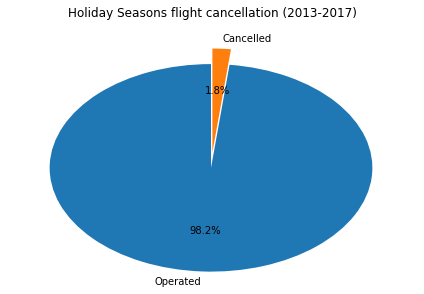

In [14]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

# colors = ["#E13F29", "#D69A80", "#D63B59"]

plt.pie(
    holidays.cancelled.value_counts(),
#     colors=colors,
    labels=['Operated', 'Cancelled'],
    explode=(0.15, 0),
    startangle=90,
    autopct='%1.1f%%'
)


# View the plot
plt.tight_layout()
plt.title("Holiday Seasons flight cancellation (2013-2017)")
plt.show();

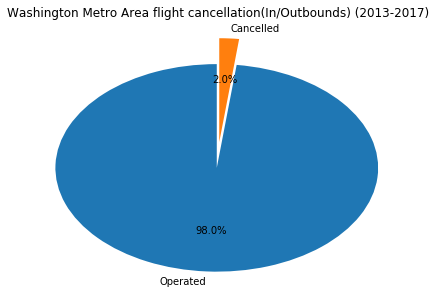

In [15]:
# inspired and courtesy of Chris Albon- https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/

plt.pie(
    washington.cancelled.value_counts(),
    labels=['Operated', 'Cancelled'],
    explode=(0.15, 0.1),
    startangle=90,
    autopct='%1.1f%%'
)

# counts = value_counter(washington.cancelled).iloc[1,1]

# View the plot
plt.tight_layout()
plt.title("Washington Metro Area flight cancellation(In/Outbounds) (2013-2017)")
# plt.text
plt.show()

In [16]:
variables_to_remove = ['taxi_out', 'taxi_in', 'wheels_on', 'wheels_off', 'system_delay',
                       'security_delay', 'carrier_delay', 'late_aircraft_delay',
                       'weather_delay', 'diverted', 'cancelled', 'cancel_code', 'air_time',
                       'year', 'month', 'day']
df_holi = holidays.drop(variables_to_remove, axis=1)
df_was = washington.drop(variables_to_remove, axis=1)

In [17]:
df_holi = df_holi[['date', 'dayofweek', 'carrier', 'flight_no', 'origin', 'dest',
         'sched_dep', 'dep_time', 'dep_delay', 'sched_arr', 'arr_time',
         'arr_delay', 'sched_elapsed', 'elapsed_time', 'distance', 'tail_no']]
df_holi[:5]

,date,dayofweek,carrier,flight_no,origin,dest,sched_dep,dep_time,dep_delay,sched_arr,arr_time,arr_delay,sched_elapsed,elapsed_time,distance,tail_no
0,2013-11-17,Sun,DL,1138,ATL,DCA,07:20:00,07:19:00,-1.0,09:00:00,08:43:00,-17.0,100.0,84.0,547.0,N906DA
1,2013-11-17,Sun,DL,1139,DCA,ATL,11:00:00,10:53:00,-7.0,12:53:00,12:52:00,-1.0,113.0,119.0,547.0,N906DA
2,2013-11-17,Sun,DL,1140,ATL,MSY,23:30:00,23:28:00,-2.0,00:01:00,23:51:00,-10.0,91.0,83.0,425.0,N663DN
3,2013-11-17,Sun,DL,1142,ATL,HOU,13:30:00,13:29:00,-1.0,14:46:00,14:41:00,-5.0,136.0,132.0,696.0,N968DL
4,2013-11-17,Sun,DL,1142,HOU,ATL,15:30:00,15:25:00,-5.0,18:27:00,18:10:00,-17.0,117.0,105.0,696.0,N968DL


In [18]:
df_was = df_was[['date', 'dayofweek', 'carrier', 'flight_no', 'origin', 'dest',
         'sched_dep', 'dep_time', 'dep_delay', 'sched_arr', 'arr_time',
         'arr_delay', 'sched_elapsed', 'elapsed_time', 'distance', 'tail_no']]
df_was[:5]

,date,dayofweek,carrier,flight_no,origin,dest,sched_dep,dep_time,dep_delay,sched_arr,arr_time,arr_delay,sched_elapsed,elapsed_time,distance,tail_no
0,2013-09-17,Tue,DL,2125,BWI,ATL,12:40:00,12:37:00,-3.0,14:33:00,14:42:00,9.0,113.0,125.0,577.0,N948DL
1,2013-09-17,Tue,DL,2137,BWI,DTW,07:40:00,07:38:00,-2.0,09:13:00,09:04:00,-9.0,93.0,86.0,409.0,N958DL
2,2013-09-17,Tue,DL,2145,DCA,DTW,19:00:00,19:32:00,32.0,20:35:00,21:01:00,26.0,95.0,89.0,405.0,N913DE
3,2013-09-17,Tue,DL,2163,DCA,MSP,06:30:00,06:49:00,19.0,08:04:00,08:33:00,29.0,154.0,164.0,931.0,N938DN
4,2013-09-17,Tue,DL,2239,DCA,ATL,17:00:00,17:15:00,15.0,18:50:00,19:24:00,34.0,110.0,129.0,547.0,N953DN


##### Aircraft dataframe clean and merge with the main dataset

In [19]:
aircrafts=pd.read_csv('./assets/aircrafts.csv', low_memory=False)
aircrafts.head(5)

,age(year),aircraft,shipped,tailno,type_code
0,NaN,NaN,NaN,N028AA,NaN
1,11 years,Bombardier CRJ-900LR,AGE (Aug 2006),N806SK,CRJ9
2,13 years,Boeing 737-8FH,AGE (Feb 2005),N549AS,B738
3,7 years,Boeing 737-890,AGE (Jan 2011),N534AS,B738
4,18 years,Airbus A319-114,AGE (Feb 2000),N314NB,A319


In [20]:
isnull_counter(aircrafts)

,variable,missing values,filling factor (%)
0,shipped,1238,80.8329
1,age(year),592,90.8345
2,aircraft,589,90.8809
3,type_code,589,90.8809
4,tailno,0,100.0000


In [21]:
aircrafts.shape

(6459, 5)

##### fuctions for the aircraft dataset

In [22]:
def clean_years(years):
    if type(years) != str:
        return(years)
    if "year" in years.lower():
        return(float(''.join([char for char in years if char.isdigit()])))
    elif "brand new" in years.lower():
        return(0)
    elif years == "-":
        return(np.nan)
    else:
        return(years)
    
def clean_aircrafts(aircrafts):
    if type(aircrafts) != str:
        return(aircrafts)
    if "age (" in aircrafts.lower():
        return aircrafts.replace("AGE (", "")[:-1]

def find_manufacture(aircraft):
    if aircraft == "-":
        return "Unknown"
    elif type(aircraft) == str:
        return aircraft.split()[0]
    else:
        return "Unknown"

top_manufacturers = aircrafts.aircraft.apply(find_manufacture).value_counts().index[0:6]

In [23]:
aircrafts['age(year)']=aircrafts['age(year)'].apply(clean_years).fillna("Unknown")
aircrafts['shipped']  =pd.to_datetime(aircrafts['shipped'].apply(clean_aircrafts))
aircrafts['aircraft'] =aircrafts.aircraft.apply(find_manufacture).apply(lambda x: "Other" if x not in top_manufacturers else x)

In [24]:
aircrafts.head()

,age(year),aircraft,shipped,tailno,type_code
0,Unknown,Unknown,NaT,N028AA,NaN
1,11,Bombardier,2006-08-01,N806SK,CRJ9
2,13,Boeing,2005-02-01,N549AS,B738
3,7,Boeing,2011-01-01,N534AS,B738
4,18,Airbus,2000-02-01,N314NB,A319


In [25]:
isnull_counter(aircrafts)

,variable,missing values,filling factor (%)
0,shipped,1238,80.8329
1,type_code,589,90.8809
2,age(year),0,100.0000
3,aircraft,0,100.0000
4,tailno,0,100.0000


### Let's merge aircraft data with main dataframe

In [26]:
print("holiday dataframe dimension   : ", df_holi.shape)
print("Washington dataframe dimension: ", df_was.shape)
print("aircraft dataframe dimension  : ", aircrafts.shape)

holiday dataframe dimension   :  (7084008, 16)
Washington dataframe dimension:  (2204853, 16)
aircraft dataframe dimension  :  (6459, 5)


In [27]:
print("df_holi tail_no counts : ", df_holi.tail_no.nunique())
print("aircrafts tailno counts: ", aircrafts.tailno.nunique())

df_holi tail_no counts :  6459
aircrafts tailno counts:  5826


In [28]:
df1 = pd.merge(df_holi, aircrafts.drop_duplicates(), how='left', left_on="tail_no", right_on="tailno")
df1.shape

(7084245, 21)

In [29]:
df2 = pd.merge(df_was, aircrafts.drop_duplicates(), how='left', left_on="tail_no", right_on="tailno")
df2.shape

(2204975, 21)

##### Save it to pickle and move to the next notebook for modeling

In [30]:
df1.to_pickle('./assets/holidays.pkl')

In [31]:
df2.to_pickle('./assets/washington.pkl')